In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sacc
import os
from scipy.interpolate import interp1d
import healpy as hp

In [2]:
def make_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [3]:
nside = 4096

dir = '../data_vectors/gaussian_sims/062722/area12300/June27/'

make_directory(dir + 'plots')

file = 'analytic_noise/twopoint_data_fourier_shot_noise_scaled.sacc'
a = sacc.Sacc.load_fits(dir+file)
a_name = 'analytic'


file = 'twopoint_theory_fourier.sacc'
t = sacc.Sacc.load_fits(dir+file)


file = 'analytic_noise/summary_statistics_fourier_shot_noise_scaled.sacc'
t_cov = sacc.Sacc.load_fits(dir+file)

#file = 'analytic_noise/summary_statistics_fourier_tjpcov_shot_noise_scaled.sacc'
#t_tjp = sacc.Sacc.load_fits(dir+file)


W = "galaxy_density_xi"
GAMMA = "galaxy_shearDensity_xi_t"
GAMMAX = "galaxy_shearDensity_xi_x"
XIP = "galaxy_shear_xi_plus"
XIM = "galaxy_shear_xi_minus"
EE = "galaxy_shear_cl_ee"
DD = "galaxy_density_cl"
ED = "galaxy_shearDensity_cl_e"


c = ["#474747", "#6992C2", "#C0E0FF", "#FADA77", "#FEB580", 'tomato', 'firebrick']

## Define scale cuts and simulation scaling factor

In [4]:
# Scaling factor for the gaussian sims
sims_factor = np.array([2., 1.5, 1.25, 1.25, 1.25])

# Redshift bins
nsbins = 5
nlbins = 5

# GGL and clustering cuts as computed in https://github.com/LSSTDESC/txpipe-cosmodc2/blob/master/notebooks/ScaleCutsSRD.ipynb
lmax_zl = [252.27086242, 401.05572005, 534.43202612, 653.61625038, 760.14254387] 
lmax_cs = 3000 #lmax for cosmic shear

#from https://github.com/CosmoLike/DESC_SRD/blob/master/gglensing_zbin_y1
GGL_combinations_dict = {
    'zl0zs0': 0,
    'zl0zs1': 0,
    'zl0zs2': 1,
    'zl0zs3': 1,
    'zl0zs4': 1,
    'zl1zs0': 0,
    'zl1zs1': 0,
    'zl1zs2': 0,
    'zl1zs3': 1,
    'zl1zs4': 1,
    'zl2zs0': 0,
    'zl2zs1': 0,
    'zl2zs2': 0,
    'zl2zs3': 0,
    'zl2zs4': 1,
    'zl3zs0': 0,
    'zl3zs1': 0,
    'zl3zs2': 0,
    'zl3zs3': 0,
    'zl3zs4': 1,
    'zl4zs0': 0,
    'zl4zs1': 0,
    'zl4zs2': 0,
    'zl4zs3': 0,
    'zl4zs4': 0}

## Build saac simulated data file with theory and covariance

In [5]:
t.get_data_types()
t.remove_selection('galaxy_shear_cl_be')
t.remove_selection('galaxy_shear_cl_eb')

In [6]:
print(t_cov.get_data_types())
print(t.get_data_types())

['galaxy_density_cl', 'galaxy_shearDensity_cl_e', 'galaxy_shear_cl_ee']
['galaxy_density_cl', 'galaxy_shearDensity_cl_e', 'galaxy_shear_cl_ee']


In [8]:
cov_f = t_cov.covariance.dense
t.add_covariance(cov_f)
t.save_fits(dir+'twopoint_theory_fourier_with_cov.sacc', overwrite=True)

## Plot bandpowers for sources

In [9]:
ind = a.indices("galaxy_shear_cl_ee", (f"source_0", f"source_0"))
bpw = a.get_bandpower_windows(ind)

Text(0, 0.5, 'TXPipe Bandpowers')

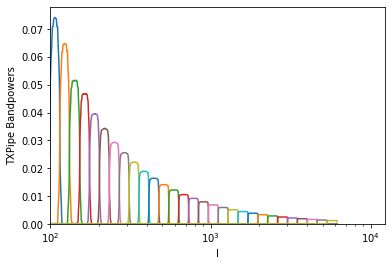

In [10]:
plt.plot(bpw.values, bpw.weight)#, 'royalblue')
plt.xscale('log')
#plt.yscale('log')
plt.xlim(100, 3*nside)
plt.ylim(ymin=0)
plt.xlabel('l')
plt.ylabel('TXPipe Bandpowers')

## Compare theory with measurements

In [11]:
def get_mean(s, dt, factor, lmax):
    dps = s.get_data_points(dt)
    mean = []
    thetas = []
    masks = []
    for dp in dps:
        # this will be the lens when clustering and gglensing. Source when cosmic shear. 
        bin = int(dp.tracers[1][-1])
        
        if dp['ell']<lmax[bin]:
            
            if dt == ED:
                source_bin = int(dp.tracers[0][-1])
                lens_bin = int(dp.tracers[1][-1])
                factor_i = factor[lens_bin]
                if GGL_combinations_dict['zl%dzs%d'%(lens_bin, source_bin)]: #SRD requirements
                #if lens_bin<=source_bin:
                    mean.append(dp.value*factor_i)
                    mask = True
                else:
                    mask = False

            if dt == DD:
                lens_bin1 = int(dp.tracers[0][-1])
                lens_bin2 = int(dp.tracers[1][-1])
                if lens_bin1==lens_bin2:
                    factor_1 = factor[lens_bin1]
                    factor_2 = factor[lens_bin2]
                    mean.append(dp.value*factor_1*factor_2)
                    mask = True
                else:
                    mask = False
            if dt == EE:
                mean.append(dp.value)
                mask = True
            
        else:
            mask = False
            
        masks.append(mask)
    mean = np.array(mean)
    masks = np.array(masks)
    return mean, masks

def get_cov(s, dt):
    ind = s.indices(dt)
    cov = s.covariance.get_block(ind)
    return cov
    
def compute_chi2_gauss(data, theory, cov_th, dt, factor = np.ones(nlbins), lmax=None):
    print('Cutting scales larger than', lmax)
    theory_mean, mask = get_mean(theory, dt, factor = np.ones(nlbins), lmax=lmax)
    data_mean, mask = get_mean(data, dt, factor, lmax=lmax)

    cov = get_cov(cov_th, dt)
    cov = (cov[mask]).T[mask]
    invcov = np.linalg.inv(cov) 
    
    deltachi2 = np.dot(np.dot(data_mean-theory_mean, invcov), data_mean-theory_mean)
    ndf = len(data_mean)
    
    ndf = len(data_mean)
    
    return deltachi2, ndf, cov

In [12]:
print('With TXFourierGaussianCovariance')

deltachi2, ndf, cov = compute_chi2_gauss(a, t, cov_th = t_cov, dt =EE, lmax = [lmax_cs]*5)
print('delta chi2/ndf shear cl  = %0.1f/%d = %0.1f'%(deltachi2, ndf, deltachi2/ndf))

deltachi2, ndf, cov = compute_chi2_gauss(a, t,cov_th = t_cov, dt =ED, factor = sims_factor, lmax = lmax_zl)
print('delta chi2/ndf galaxy-shear cl (bin comb. in SRD doc.) = %0.1f/%d = %0.1f'%(deltachi2, ndf, deltachi2/ndf))

deltachi2, ndf, cov = compute_chi2_gauss(a, t, cov_th = t_cov, dt =DD, factor = sims_factor, lmax = lmax_zl)
print('delta chi2/ndf galaxy cl (only auto correlations) = %0.1f/%d = %0.1f'%(deltachi2, ndf, deltachi2/ndf))


With TXFourierGaussianCovariance
Cutting scales larger than [3000, 3000, 3000, 3000, 3000]
delta chi2/ndf shear cl  = 452.9/360 = 1.3
Cutting scales larger than [252.27086242, 401.05572005, 534.43202612, 653.61625038, 760.14254387]
delta chi2/ndf galaxy-shear cl (bin comb. in SRD doc.) = 59.0/66 = 0.9
Cutting scales larger than [252.27086242, 401.05572005, 534.43202612, 653.61625038, 760.14254387]
delta chi2/ndf galaxy cl (only auto correlations) = 55.9/56 = 1.0


# Plot noise 

In [16]:
def arcmin2_to_rad2(density):
    return density*60**2*41253/(4*np.pi)

def plot_noise_clustering(s, s2=None,maps = None, datatype=None, density_arcmin=None, shot_noise=None, ratios=False):
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif")
    
    for dt in s.get_data_types():
        
        if dt == EE:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == ED:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == DD:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            # noise is 0 for cross-correlations, only matters for auto redshift bins
            fig, ax = plt.subplots(1, nbins1, figsize=(1.8*nsbins, 1.8*0.95), sharey=True, sharex=True)

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
           
            
            for i in range(nbins1):
                    ell, cl = s.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, i))
                    n_ell = s.get_tag( 'n_ell', data_type=dt, tracers=('%s_%s'%(name1,i),'%s_%s'%(name2, i)) )
                    n_ell_coupled = s.tracers['%s_%s'%(name1,i)].metadata['n_ell_coupled']
                    
                    ax[i].plot(ell, np.array(n_ell)*sims_factor[i]**2, ls = '-', lw = '1.5', color = c[2], label = r'TXPipe noise decoupled $\times f_{sims}^2$')
                    if shot_noise is not None:
                        ax[i].plot(ell, [shot_noise[i]]*len(ell), ls = '-', lw = '1.5', color = c[1], label = 'Shot noise Yuuki')

                    if density_arcmin is not None:
                        density_rad = arcmin2_to_rad2(density_arcmin[i])
                        noise_direct = 1/density_rad
                        ax[i].plot(ell, [noise_direct]*len(ell), ls = ':', lw = '1.5', color = c[0], label = r'$f_{sims}^2$/ndens ')
                        

                    ax[i].set_xscale('log')
                    ax[i].set_yscale('log')
                    ax[i].set_xlabel(r'$\ell$')
                    ax[0].set_ylabel(r'Clustering Noise')



    ax[0].legend(frameon = False,bbox_to_anchor = (8., 0.94))

    return fig



def arcmin2_to_rad2(density):
    return density*60**2*41253/(4*np.pi)

def plot_noise_analytic_vs_maps(s_maps, datatype=None, s_analytic=None, density_arcmin=None):
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif")
        
    for dt in s.get_data_types():
        
        if dt == EE:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == ED:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == DD:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            # noise is 0 for cross-correlations, only matters for auto redshift bins
            fig, ax = plt.subplots(1, nbins1, figsize=(1.8*nsbins, 1.8*0.95), sharey=True, sharex=True)

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
           
            
            for i in range(nbins1):
                    ell, cl = s_maps.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, i))
                    n_ell = s_maps.get_tag( 'n_ell', data_type=dt, tracers=('%s_%s'%(name1,i),'%s_%s'%(name2, i)) )
                    n_ell_coupled = s_maps.tracers['%s_%s'%(name1,i)].metadata['n_ell_coupled']
                    #ax[i].plot(ell, [3.21*10**(-9)]*len(ell), ls = '--', lw = '1.5', color = 'k', label = 'From Yuuki old')
                    if compare is not None:
                        n_ell_analytic = s_analytic.get_tag( 'n_ell', data_type=dt, tracers=('%s_%s'%(name1,i),'%s_%s'%(name2, i)) )
                        n_ell_coupled_analytic = s_analytic.tracers['%s_%s'%(name1,i)].metadata['n_ell_coupled']
                    if n_ell is not None:
                      
                        ax[i].plot(ell, np.array(n_ell), ls = '-', lw = '1.5', color = c[1], label = 'From maps')
                        ax[i].plot(ell, n_ell_analytic, ls = '--', lw = '1.5', color = c[1], label = 'Analytic')
                        ax[i].plot(ell, [n_ell_coupled]*len(ell), ls = '-', lw = '1.5', color = c[4], label = 'From maps coupled')
                        ax[i].plot(ell, [n_ell_coupled_analytic]*len(ell), ls = '--', lw = '1.5', color = c[4], label = 'Analytic coupled')
            
                    print(np.mean(np.array(n_ell_analytic)/(3.21*10**(-9))))
                    if density_arcmin is not None:
                        density_rad = arcmin2_to_rad2(density_arcmin[i])
                        noise_direct = 1/density_rad
                        ax[i].plot(ell, [noise_direct]*len(ell), ls = ':', lw = '1.5', color = c[0], label = '1/ndens')
                    
                    ax[i].set_xscale('log')
                    ax[i].set_yscale('log')
                
                    ax[i].set_xlabel(r'$\ell$')
                
    
                    if dt == DD:
                        ax[0].set_ylabel(r'Clustering Noise')
                    if dt == EE:
                        ax[0].set_ylabel(r'Cosmic shear Noise')


    ax[0].legend(frameon = False,bbox_to_anchor = (6.9, 0.94))

    return fig


def plot_noise_shear(analytic, maps = None, datatype=None,  shape_noise = None,ratios=False, nbar_arcmin = None):
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif")
    
    for dt in analytic.get_data_types():
        
        if dt == EE:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == ED:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == DD:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            # noise is 0 for cross-correlations, only matters for auto redshift bins
            fig, ax = plt.subplots(1, nbins1, figsize=(1.8*nsbins, 1.8*0.95), sharey=True, sharex=True)

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
           
            
            for i in range(nbins1):
                    ell, cl = analytic.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, i))
                    n_ell_analytic = analytic.get_tag( 'n_ell', data_type=dt, tracers=('%s_%s'%(name1,i),'%s_%s'%(name2, i)) )
                    n_ell_coupled_analytic = analytic.tracers['%s_%s'%(name1,i)].metadata['n_ell_coupled']
                    print('n_ell_coupled_analytic', i, n_ell_coupled_analytic)
                    if maps is not None:
                        n_ell_maps= maps.get_tag( 'n_ell', data_type=dt, tracers=('%s_%s'%(name1,i),'%s_%s'%(name2, i)) )
                        n_ell_coupled_maps = maps.tracers['%s_%s'%(name1,i)].metadata['n_ell_coupled']
                    
                
                    if not ratios:
                        ax[i].plot(ell, np.array(n_ell_analytic), ls = '-', lw = '1.5', color = c[2], label = r'TXPipe noise analytic decoupled')
                        #print('np.array(n_ell_analytic)',np.array(n_ell_analytic))
                        if maps is not None:
                            ax[i].plot(ell, np.array(n_ell_maps), ls = '--', lw = '1.5', color = c[2], label = r'TXPipe noise maps decoupled')
                        
                        ax[i].plot(ell, [n_ell_coupled_analytic]*len(ell), ls = '-', lw = '1.5', color = c[4], label = 'TXPipe analytic coupled')
                        if maps is not None:
                            ax[i].plot(ell, [n_ell_coupled_maps]*len(ell), ls = '--', lw = '1.5', color = c[4], label = 'TXPipe maps coupled')
                        
                        ax[i].plot(ell, [2.6430195875724863e-08]*len(ell), 'k',ls=':', label = r'np.mean(var map)$\times $pxarea in TXPipe')
                        nbar_rad = arcmin2_to_rad2(nbar_arcmin)   
                        ax[i].plot(ell, [0.26**2/nbar_rad]*len(ell), 'k',ls='--', label = r'$0.26^2/n$')
      
                    
                    if ratios:
                        ax[i].plot(ell, [np.mean(shape_noise[i])/np.mean(np.array(n_ell))]*len(ell), ls = '-', lw = '1.5', color = c[2], label = r'Shot noise Yuuki/TXPipe noise analytic decoupled')
                        print(np.mean(shape_noise[i])/np.mean(np.array(n_ell)))
                    else:
                        ax[i].plot(np.arange(len(shape_noise[i])), shape_noise[i], ls = '-', lw = '1.5', color = c[1], label = 'Shape noise Yuuki')
                        #print('shape_noise yuuki[i]', shape_noise[i])
                        #yuuki_m = np.loadtxt(dir + 'yomori_measurements/nls_l%d_s%d_l%d_s%d_seed999.dat'%(i, i, i, i))# noise
                        #ell_y, TT_y, EE_n, BB_y, TE_y, TB_y, EB_y, ET_y, BT_y, BE_y = yuuki_m.T
                        #ax[i].plot(ell_y, EE_n, ls = '-', lw = '0.3', color = 'gray', label = 'Shape noise Yuuki updated')
                    

                    ax[i].set_xscale('log')
                    ax[i].set_xlim(100, 3000)
                    ax[i].set_yscale('log')
                
                    ax[i].set_xlabel(r'$\ell$')

                    ax[0].set_ylabel(r'Cosmic shear Noise')


    ax[0].legend(frameon = False,bbox_to_anchor = (8., 0.94))

    return fig




In [36]:
shot = np.loadtxt('/Users/juditprat/Dropbox/projects/lsst/txpipe-cosmodc2/data_vectors/gaussian_sims/022422/area12300/March2/new_scales/CovarianceFourierFromSims/041822/shotnl.dat') #from Yuuki
shot = shot[0].T # constant accross ells

shape = np.loadtxt('/Users/juditprat/Dropbox/projects/lsst/txpipe-cosmodc2/data_vectors/gaussian_sims/022422/area12300/March2/new_scales/CovarianceFourierFromSims/041822/shapenl.dat') #from Yuuki

[2.25155186 3.11027006 3.089222   2.60661357 2.00483612]
galaxy_density_cl


<Figure size 432x288 with 0 Axes>

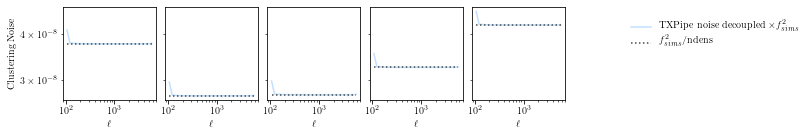

In [25]:
lens_density = np.array([9.006207438018485, 6.99810762623, 4.826909375520461, 4.072833698955003, 3.132556436117557])
lens_density_scaled = np.array([lens_density[i]/sims_factor[i]**2 for i in range(len(lens_density))])
print(lens_density_scaled)
#s, s2=None,maps = None, datatype=None, density_arcmin=None, shot_noise=None, ratios=False
fig = plot_noise_clustering(a, datatype=DD,  density_arcmin = lens_density_scaled, shot_noise=None)
make_directory(dir + 'plots/noise/')
plt.savefig(dir + 'plots/noise/' + 'cl_galaxy_noise_scaled_TXPipe.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shear_cl_ee
n_ell_coupled_analytic 0 2.64485784985553e-08
n_ell_coupled_analytic 1 2.64629076056488e-08
n_ell_coupled_analytic 2 2.64740825737809e-08
n_ell_coupled_analytic 3 2.65022850923656e-08
n_ell_coupled_analytic 4 2.65723293222938e-08


<Figure size 432x288 with 0 Axes>

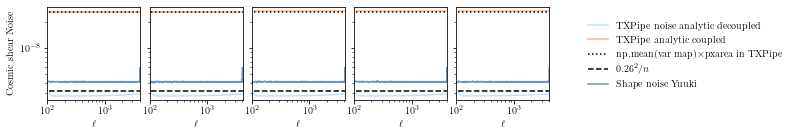

In [42]:
nbar_arcmin = 1.78
nbar_rad = arcmin2_to_rad2(nbar_arcmin)
fig = plot_noise_shear(a,maps=None, datatype=EE, shape_noise=shape.T, ratios = False, nbar_arcmin = nbar_arcmin)
make_directory(dir + 'plots/noise/')
plt.savefig(dir + 'plots/noise/' + 'cl_shear_noise.png', dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

In [13]:
nbar_rad 

21036242.851053346

In [39]:
nbar_rad*hp.pixelfunc.nside2pixarea(nside) #mean number of gal per pixel

5.248901488780975

# Make the actual measurement plots here

In [13]:
def plot_twopoint(s, theory=None, theory_cov = None, s2 =None, datatype=None, ratios = False, diff = False, diff_with_errors=False, plot_noise=False):

        
    for dt in s.get_data_types():
        
        if dt == EE:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == ED:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == DD:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            for i in range(nbins1):
                for j in range(nbins2):

                    ell, cl = s.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j))
                    if s2 is not None:
                        ell2, cl2 = s2.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j))

                    n_ell_analytic = s.get_tag( 'n_ell', data_type=dt, tracers=('%s_%s'%(name1,i),'%s_%s'%(name2, i)) )

                    if i>=j:
                        if datatype == ED:
                            cl = cl*sims_factor[j]
                            if s2 is not None:
                                cl2 = cl2*sims_factor[j]
                        if datatype == DD:
                            cl = cl*sims_factor[j]*sims_factor[i]
                            if s2 is not None:
                                cl2 = cl2*sims_factor[j]*sims_factor[i]

                        if theory_cov is not None:
                            _, _, cov = theory_cov.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                            err = np.sqrt(np.diag(cov))  
                    
                        if theory is not None:
                            ell_th, cl_th = theory.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = False)
                        if ratios:
                            if len(cl_th[cl_th==0])==0:
                                ax[i][j].errorbar(ell, cl/cl_th, err/cl_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurement/Theory')
                                if s2 is not None:
                                    ax[i][j].plot(ell, cl2/cl, '-',  lw = 2,  color = c[2], label = 'Measurements Yuuki/Measurements')
                        elif diff:
                            ax[i][j].errorbar(ell, cl-cl_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurement-Theory')
                            ax[i][j].fill_between(theta, -err, err, alpha = 0.5, color = 'powderblue')

                        else:
                            ax[i][j].plot(ell, cl_th, ls = '-', lw = '1.5', color = c[1], label = 'Theory')
                            ax[i][j].errorbar(ell, cl, err, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurements')
                            if s2 is not None:
                                ax[i][j].errorbar(ell2, cl2, err, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[3], label = 'Measurements Yuuki')
                            if plot_noise:
                                if i==j:
                                    if datatype == EE:

                                        ax[i][j].plot(ell, np.array(n_ell_analytic), ls = ':', lw = '2.', color = c[1], label = r'TXPipe noise analytic decoupled ')
                                    if datatype == DD:

                                        ax[i][j].plot(ell, np.array(n_ell_analytic)*sims_factor[j]**2, ls = ':', lw = '1.5', color = c[1], label = r'TXPipe noise analytic decoupled $\times f_{sims}^2$')

                        if (datatype==EE) or ((datatype==DD or datatype==ED) and j>0 or i>0):
                            ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                        verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                    
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(100, 6000)
                    #ax[k][j].axvspan(lmax_zl, 6000, color='lightgrey', alpha = 0.3)

                    if ratios:
                        ax[i][j].set_ylim(0.6, 1.4)
                        ax[i][j].axhline(y =1, ls = ':', color = 'k')
                    elif diff:
                        ax[i][j].set_ylim(-0.00001, 0.000005)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    elif diff_with_errors:
                        ax[i][j].set_ylim(-3, 3.)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    else:
                        ax[i][j].set_yscale('log')
                        if datatype==EE:
                            ax[i][j].set_ylim(10**(-12), 2*10**(-8))
                        if datatype==ED:
                            ax[i][j].set_ylim(10**(-10), 6*10**(-7))
                        if datatype==DD:
                            ax[i][j].set_ylim(10**(-9), 10**(-5))                            

                    if i==nbins1-1: 
                        ax[i][j].set_xlabel(r'$\ell$')
                
                    if j==0:
                        if datatype==EE:
                            ax[i][j].set_ylabel(r'$C_{\gamma \gamma}(\ell)$')
                        if datatype==ED:
                            ax[i][j].set_ylabel(r'$C_{\delta \gamma}(\ell)$')
                        if datatype==DD:
                            ax[i][j].set_ylabel(r'$C_{\delta \delta}(\ell)$')

                            
                    if i<j:
                        fig.delaxes(ax[i, j])
    

    return fig


galaxy_shear_cl_ee


/Users/juditprat/anaconda3/anaconda3/lib/python3.7/site-packages/sacc/sacc.py:370: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


<Figure size 432x288 with 0 Axes>

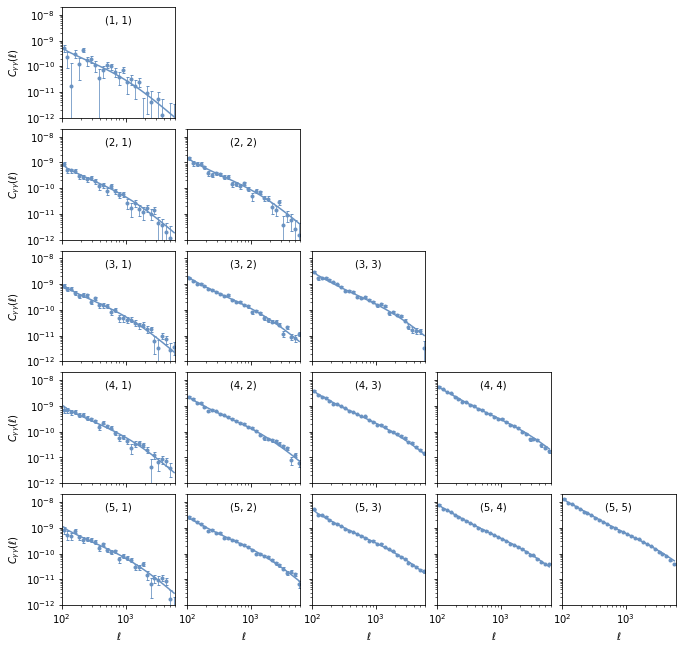

In [19]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov, datatype=EE, ratios = False, diff = False, diff_with_errors = False,plot_noise=False)
plt.savefig(dir + 'plots/' + 'cl_shear_%s'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_cl_e


<Figure size 432x288 with 0 Axes>

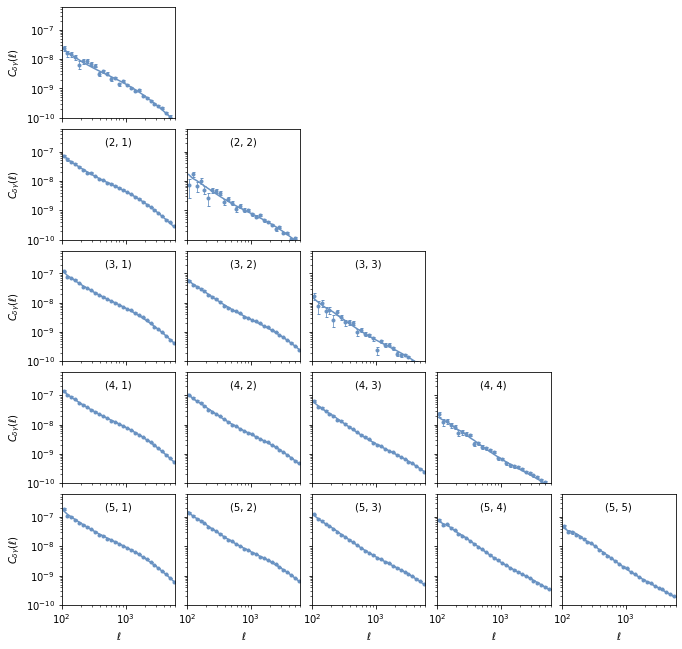

In [22]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov, datatype=ED, ratios = False, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxyshear_%s'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_density_cl


<Figure size 432x288 with 0 Axes>

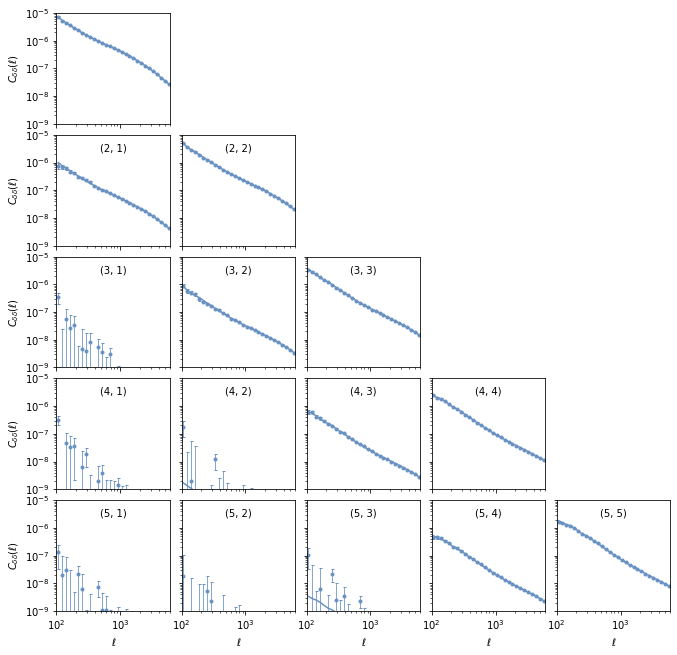

In [21]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov, datatype=DD, ratios = False, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxy_%s'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_density_cl


<Figure size 432x288 with 0 Axes>

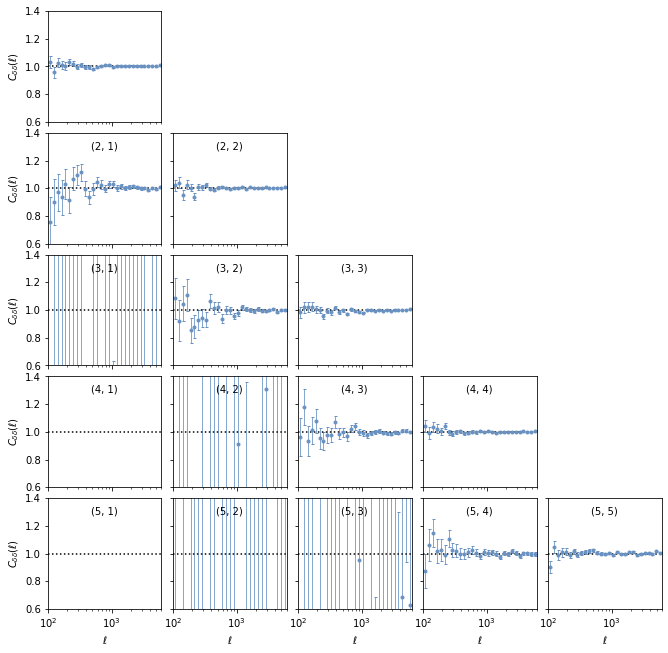

In [27]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov, datatype=DD, ratios = True, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxy_%s_ratios'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_density_cl


<Figure size 432x288 with 0 Axes>

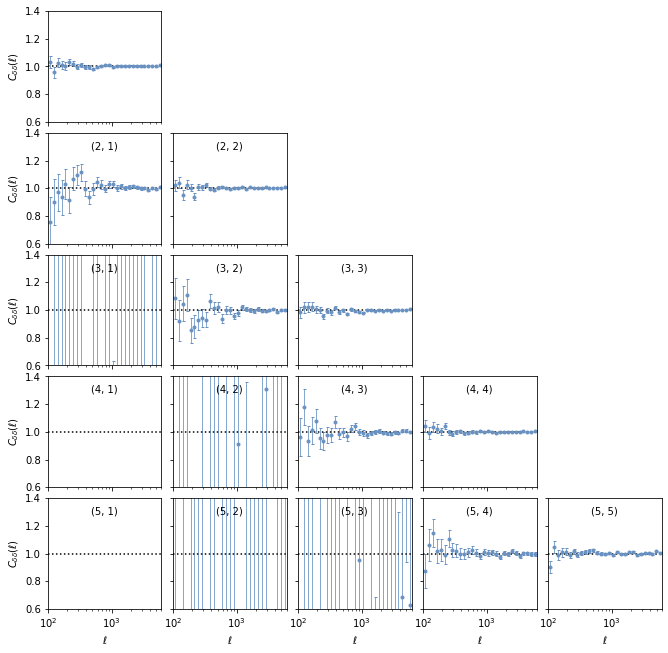

In [28]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov, datatype=DD, ratios = True, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxy_%s_ratios_largeellmax'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shear_cl_ee


<Figure size 432x288 with 0 Axes>

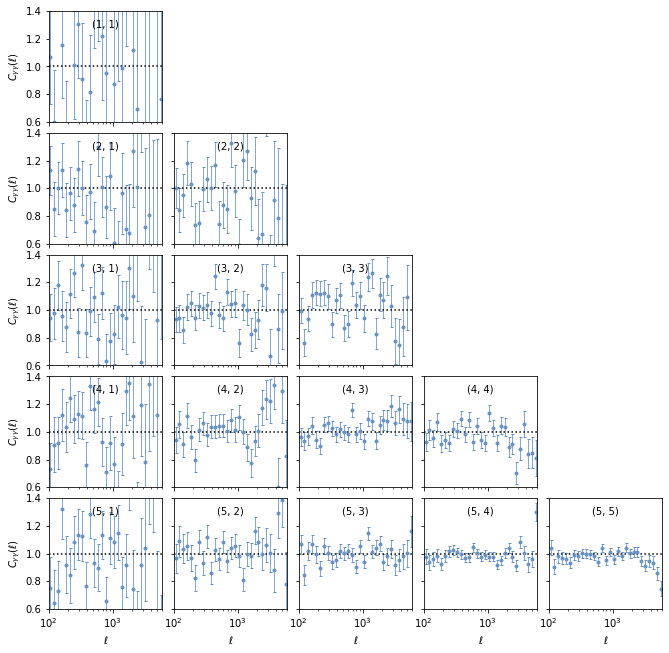

In [29]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov, datatype=EE, ratios = True, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_shear_%s_ratios'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

galaxy_shearDensity_cl_e


<Figure size 432x288 with 0 Axes>

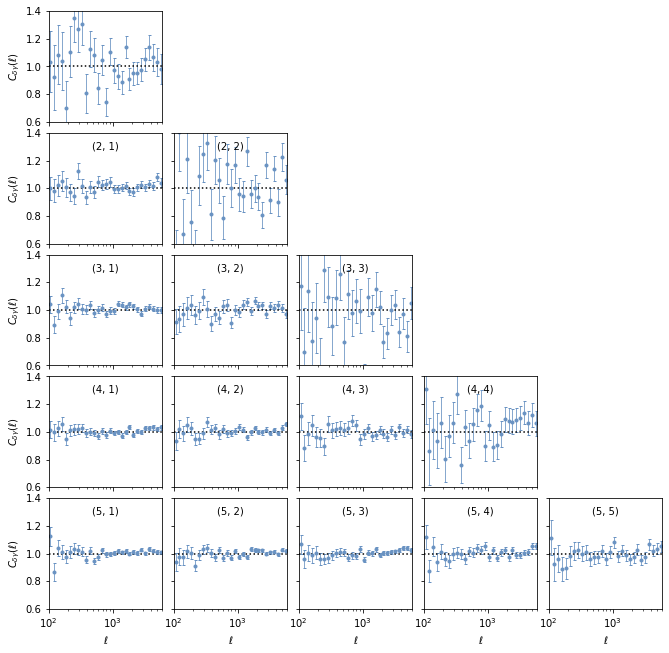

In [30]:
fig = plot_twopoint(a, theory=t, theory_cov = t_cov, datatype=ED, ratios = True, diff = False, diff_with_errors = False)
plt.savefig(dir + 'plots/' + 'cl_galaxyshear_%s_ratios'%a_name, dpi = 500, bbox_inches = 'tight',  pad_inches = 0.1)

In [31]:
def plot_errorbars(s, theory_cov = None,  theory_cov2 = None, datatype=None, ratios = False):
      
    for dt in s.get_data_types():
        
        if dt == EE:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == ED:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == DD:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            
            for i in range(nbins1):
                for j in range(nbins2):

                    ell, _ = s.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j))
                    if i>=j:

                        if theory_cov is not None:
                            # this returns the theory cov, and overwrites the error if theory_cov is not None
                            _, _, cov = theory_cov.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                            err = np.sqrt(np.diag(cov))  
                            
                        if theory_cov2 is not None:
                            _, _, cov2 = theory_cov2.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                            err2 = np.sqrt(np.diag(cov2))  
                    
                        if not ratios:
                            ax[i][j].plot(ell, err, ls = '-', lw = '1.5', color = c[1], label = 'TXFourierGaussianCov')
                            if theory_cov2 is not None:
                                ax[i][j].plot(ell, err2, ls = '-', lw = '1.5', color = c[3], label = 'TXFourierTJPCov')

                        if ratios:
                            ax[i][j].plot(ell, err2/err, ls = '-', lw = '1.5', color = c[1], label = 'TXFourierTJPCov/TXFourierGaussianCov')

                        if (datatype==EE) or ((datatype==DD or datatype==ED) and j>0 or i>0):
                            ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                        verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                            
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(100, nside*3)
                    if not ratios:
                        ax[i][j].set_yscale('log')
                    if ratios:
                        
                        ax[i][j].set_ylim(0.5, 2.)
                        

                    if i==nbins1-1: 
                        ax[i][j].set_xlabel(r'$\ell$')
                
                    if j==0:
                        if datatype==EE:
                            ax[i][j].set_ylabel(r'$\sigma (C_{\gamma \gamma})$')
                        if datatype==ED:
                            ax[i][j].set_ylabel(r'$\sigma (C_{\delta \gamma})$')
                        if datatype==DD:
                            ax[i][j].set_ylabel(r'$\sigma (C_{\delta \delta})$')

                    if i<j:
                        fig.delaxes(ax[i, j])
    
    ax[0][0].legend(frameon = False, loc = 'best', bbox_to_anchor=(2., 0.5, 0.5, 0.5))

    return fig


In [32]:
def plot_twopoint_theory(s, theory=None, theory_cov = None, datatype=None, ratios = False, diff = False, diff_with_errors=False):

        
    for dt in s.get_data_types():
        
        if dt == EE:
            nbins1 = nsbins
            nbins2 = nsbins
            name1 = 'source'
            name2 = 'source'
        
        if dt == ED:
            nbins1 = nsbins
            nbins2 = nlbins
            name1 = 'source'
            name2 = 'lens'

        if dt == DD:
            nbins1 = nlbins
            nbins2 = nlbins
            name1 = 'lens'
            name2 = 'lens'
            
        if dt == datatype:
            print(dt)
            plt.clf()
            fig, ax = plt.subplots(nbins1, nbins2, figsize=(2.2*nbins1, 2.2*nbins2), sharey=True, sharex=True)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            for i in range(nbins1):
                for j in range(nbins2):

                    ell, cl = s.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j))
                    if theory_cov is not None:
                        # this returns the theory cov, and overwrites the error if theory_cov is not None
                        _, _, cov = theory_cov.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = True)
                        err = np.sqrt(np.diag(cov))  
                    
                    if theory is not None:
                        ell_th, cl_th = theory.get_ell_cl(dt,'%s_%s'%(name1,i) , '%s_%s'%(name2, j), return_cov = False)
                    if ratios:
                        if len(cl_th[cl_th==0])==0:
                            ax[i][j].errorbar(ell, cl/cl_th, err/cl_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Theory binned properly/Theory')
                    elif diff:
                        ax[i][j].errorbar(ell, cl-cl_th, fmt = '.',  capsize=1.5, elinewidth=0.8, color = c[1], label = 'Measurement-Theory')
                        ax[i][j].fill_between(theta, -err, err, alpha = 0.5, color = 'powderblue')

                    else:
                        ax[i][j].plot(ell, cl_th, ls = '-', lw = '1.5', color = c[1], label = 'Theory')
                        ax[i][j].errorbar(ell, cl, err, fmt = '.', capsize=1.5, elinewidth=0.8, color = c[1], label = 'Theory binned properly')

                    if (datatype==EE) or ((datatype==DD or datatype==ED) and j>0 or i>0):
                        ax[i][j].text(0.5, 0.88, "(%d, %d)"%(i+1, j+1), horizontalalignment='center',
                                    verticalalignment='center', transform=ax[i][j].transAxes)#, fontsize=12)
                    
                    ax[i][j].set_xscale('log')
                    ax[i][j].set_xlim(100, 2*nside)

                    if ratios:
                        ax[i][j].set_ylim(0.95, 1.05)
                        ax[i][j].axhline(y =1, ls = ':', color = 'k')
                    elif diff:
                        ax[i][j].set_ylim(-0.00001, 0.000005)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    elif diff_with_errors:
                        ax[i][j].set_ylim(-3, 3.)
                        ax[i][j].axhline(y =0, ls = ':', color = 'k')
                    else:
                        ax[i][j].set_yscale('log')
                        if datatype==EE:
                            ax[i][j].set_ylim(8*10**(-12), 10**(-8))
                        if datatype==ED:
                            ax[i][j].set_ylim(8*10**(-11), 10**(-7))
                        if datatype==DD:
                            ax[i][j].set_ylim(10**(-9), 10**(-5))                            

                    if i==nbins1-1: 
                        ax[i][j].set_xlabel(r'$\ell$')
                
                    if j==0:
                        if datatype==EE:
                            ax[i][j].set_ylabel(r'$C_{\gamma \gamma}(\ell)$')
                        if datatype==ED:
                            ax[i][j].set_ylabel(r'$C_{\delta \gamma}(\ell)$')
                        if datatype==DD:
                            ax[i][j].set_ylabel(r'$C_{\delta \delta}(\ell)$')

                            
                    #if datatype!=ED:
                    if i<j:
                        fig.delaxes(ax[i, j])
    
    ax[0][0].legend(frameon = False, loc = 'best')

    return fig
